- Purpose behind building this project, is to create a machine learning workflow/   pipeline to detect the flood with satellite images and give the early warning to the monitoring body.

- I've choosen Jorhat district area from Assam state of India, which is flood prone, in Jorhat flood was seen in june 2022 and july 2023, because flood crisis occured in two consecutive years, this idea came in my mind.

- Jorhat district is considered among one of the highly flood-prone zones in Assam. Flood-prone areas near Jorhat include Teok, particularly riverbank settlements like Jajimukh, due to the swell of the Brahmaputra River and its tributaries, and other settlements along the Bhogdoi River as it flows through the city.

- Satellite images source: https://search.asf.alaska.edu/ [ASF Vertex search portal]

- Preprocessing Satellite image (.tif format) was done in QGIS software: https://qgis.org/

- Intially i tried,training the model with pytorch, using U-Net Model, but it repeatedly failed due to a persistent numerical instability error, causing the training loss to become nan (Not a Number) or -inf (infinity).

- Therefore, I used Random Forest Classifier Model.

In [1]:
#importing the necessary libraries
!pip install rasterio scikit-learn -q
import numpy as np
import rasterio
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import pandas as pd
from tqdm import tqdm
import joblib
import os

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.3/22.3 MB 41.0 MB/s eta 0:00:00


In [2]:
# Define the paths
base_path = '/content/drive/MyDrive/Flood_project/clipped_data/'
pre_flood_path = base_path + 'pre_flood_2022.tif'
during_flood_path = base_path + 'during_flood_2022.tif'
ground_truth_path = base_path + 'ground_truth_2022.tif'

# Load the data
with rasterio.open(pre_flood_path) as src: pre_flood_img = src.read(1).astype(np.float32)
with rasterio.open(during_flood_path) as src: during_flood_img = src.read(1).astype(np.float32)
with rasterio.open(ground_truth_path) as src: ground_truth_img = src.read(1)

ground_truth_img[ground_truth_img > 0] = 1

In [3]:
# Getting image dimensions
height, width = pre_flood_img.shape
# We will train on a random sample of 200,000 pixels to be fast and memory-safe
num_samples = 200000

random_x = np.random.randint(0, width, size=num_samples)
random_y = np.random.randint(0, height, size=num_samples)

pre_flood_samples = pre_flood_img[random_y, random_x]
during_flood_samples = during_flood_img[random_y, random_x]
gt_samples = ground_truth_img[random_y, random_x]

X_train = pd.DataFrame({
    'pre_flood': pre_flood_samples,
    'during_flood': during_flood_samples
})
y_train = pd.Series(gt_samples).astype(int)

In [5]:
#Now we'll train the Random Forest Model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1, max_samples=0.5)
rf_model.fit(X_train, y_train)
print("Model training complete!!!")

Model training complete!!!


Testing model on the unseen data 2023 flood event

In [8]:
# paths to the 2023 data
pre_flood_path_2023 = base_path + 'pre_flood_2023.tif'
during_flood_path_2023 = base_path + 'during_flood_2023.tif'

# Load the 2023 images
with rasterio.open(pre_flood_path_2023) as src: pre_flood_2023 = src.read(1).astype(np.float32)
with rasterio.open(during_flood_path_2023) as src: during_flood_2023 = src.read(1).astype(np.float32)

#this will Auto-generate the correct ground truth for the 2023 image in memory
water_threshold = 0.05
ground_truth_2023_correct = (during_flood_2023 < water_threshold).astype(np.uint8)

In [9]:
# Make prediction on the full 2023 image in chunks
print("\nMaking a prediction on the full 2023 image (in chunks)...")
height_2023, width_2023 = pre_flood_2023.shape
chunk_size = 1000
prediction_map_2023 = np.zeros((height_2023, width_2023), dtype=np.uint8)

for i in tqdm(range(0, height_2023, chunk_size), desc="Predicting 2023 Flood"):
    start_row, end_row = i, min(i + chunk_size, height_2023)
    pre_chunk, during_chunk = pre_flood_2023[start_row:end_row, :], during_flood_2023[start_row:end_row, :]
    chunk_df = pd.DataFrame({'pre_flood': pre_chunk.flatten(), 'during_flood': during_chunk.flatten()})
    chunk_prediction = rf_model.predict(chunk_df)
    prediction_map_2023[start_row:end_row, :] = chunk_prediction.reshape(pre_chunk.shape)


Making a prediction on the full 2023 image (in chunks)...


Predicting 2023 Flood: 100%|██████████| 5/5 [00:43<00:00,  8.67s/it]



Displaying the final test results for 2023...


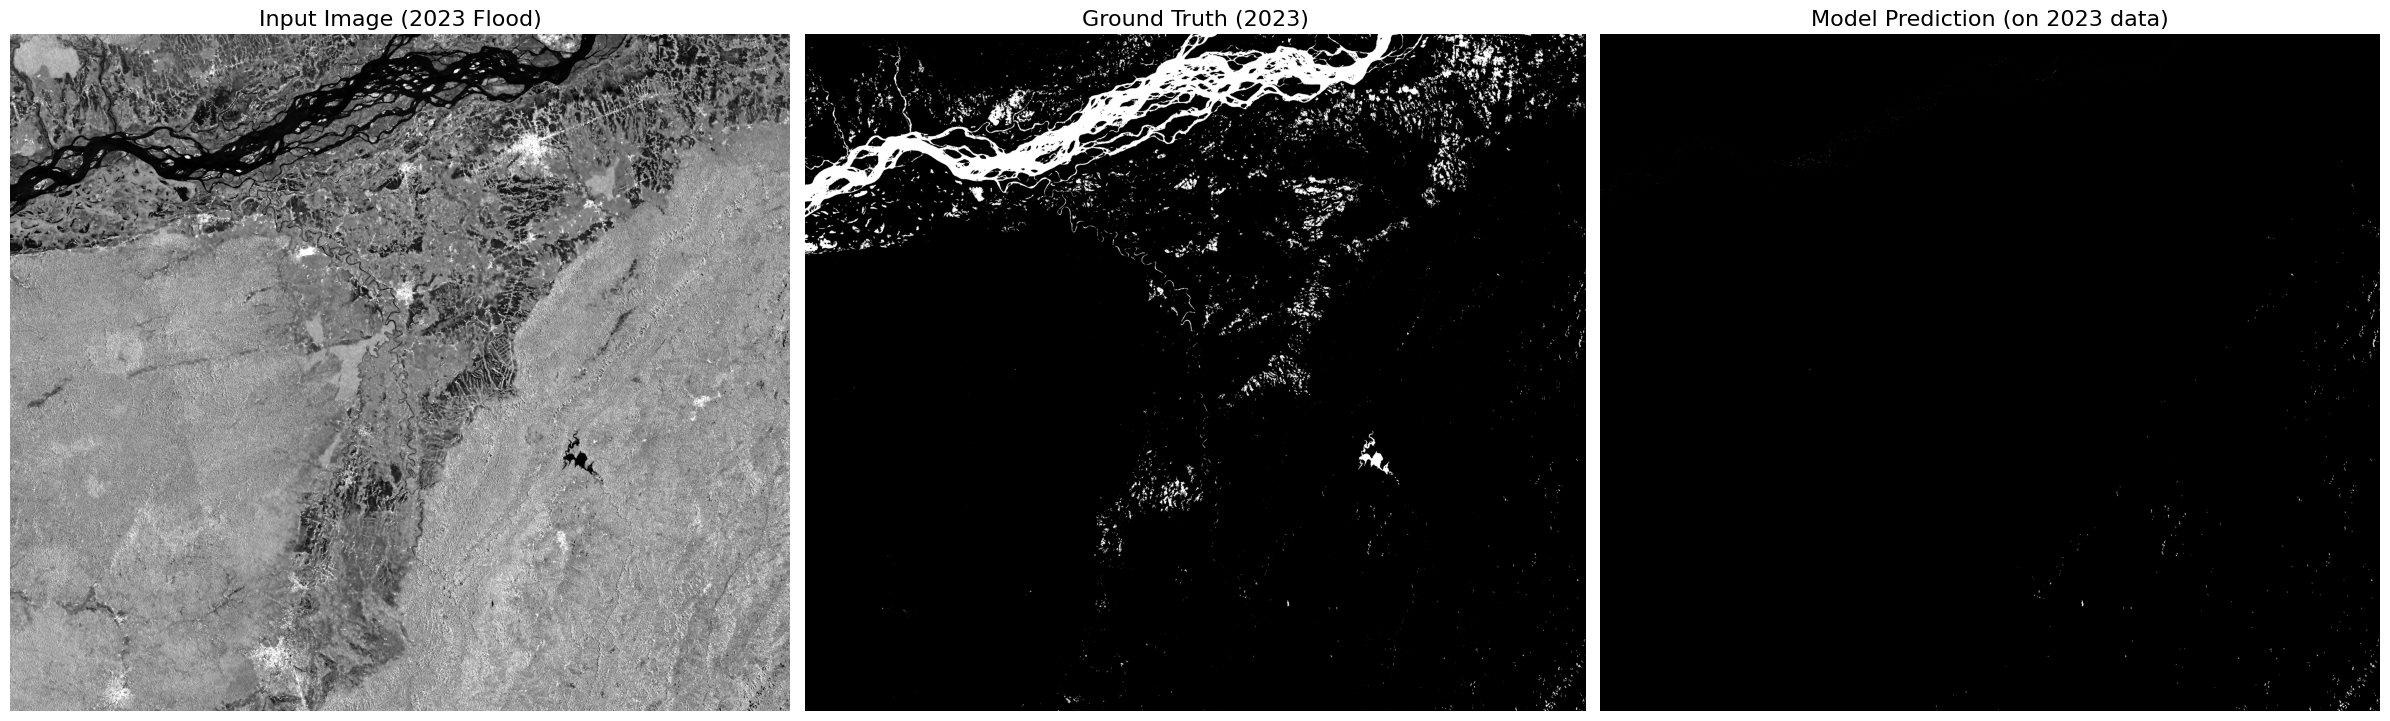

In [10]:
# Displaying the final test results
print("\nDisplaying the final test results for 2023...")
fig_2023, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 8))
ax1.imshow(during_flood_2023, cmap='gray', vmin=0.0, vmax=0.4); ax1.set_title('Input Image (2023 Flood)', fontsize=16); ax1.axis('off')
ax2.imshow(ground_truth_2023_correct, cmap='gray'); ax2.set_title('Ground Truth (2023)', fontsize=16); ax2.axis('off')
ax3.imshow(prediction_map_2023, cmap='gray'); ax3.set_title('Model Prediction (on 2023 data)', fontsize=16); ax3.axis('off')
plt.tight_layout(); plt.show()

In [11]:
# Evaluate and print accuracy
accuracy_2023 = accuracy_score(ground_truth_2023_correct.flatten(), prediction_map_2023.flatten())
print(f"\nModel Accuracy on the 2023 flood event: {accuracy_2023 * 100:.2f}%")


Model Accuracy on the 2023 flood event: 99.94%


In [12]:
#final classification
total_pixels_2023 = prediction_map_2023.size
water_pixels_2023 = np.sum(prediction_map_2023 == 1)
flood_percentage_2023 = (water_pixels_2023 / total_pixels_2023) * 100
print(f"Percentage of area detected as water: {flood_percentage_2023:.2f}%")

if flood_percentage_2023 > 5.0: # Set a threshold for what constitutes a "significant" flood
    print(" Significant Flood Detected")
else:
    print(" No Significant Flood Detected")

Percentage of area detected as water: 5.52%
 Significant Flood Detected


Again we will Test on Unseen Data of year 2020

In [25]:
# Defining the paths to the 2020 data
pre_flood_path_2020 = base_path + 'pre_flood_2020.tif'
during_flood_path_2020 = base_path + 'during_flood_2020.tif'

# Load the 2020 images
with rasterio.open(pre_flood_path_2020) as src: pre_flood_2020 = src.read(1).astype(np.float32)
with rasterio.open(during_flood_path_2020) as src: during_flood_2020 = src.read(1).astype(np.float32)

# Auto-generate the correct ground truth for the 2020 image in memory
water_threshold = 0.05
ground_truth_2020_correct = (during_flood_2020 < water_threshold).astype(np.uint8)

In [26]:
# Making the prediction on the full 2020 image in chunks
height_2020, width_2020 = pre_flood_2020.shape
chunk_size = 1000
prediction_map_2020 = np.zeros((height_2020, width_2020), dtype=np.uint8)

for i in tqdm(range(0, height_2020, chunk_size), desc="Predicting 2020 Flood"):
    start_row, end_row = i, min(i + chunk_size, height_2020)
    pre_chunk, during_chunk = pre_flood_2020[start_row:end_row, :], during_flood_2020[start_row:end_row, :]
    chunk_df = pd.DataFrame({'pre_flood': pre_chunk.flatten(), 'during_flood': during_chunk.flatten()})
    chunk_prediction = rf_model.predict(chunk_df)
    prediction_map_2020[start_row:end_row, :] = chunk_prediction.reshape(pre_chunk.shape)

Predicting 2020 Flood: 100%|██████████| 5/5 [00:41<00:00,  8.30s/it]


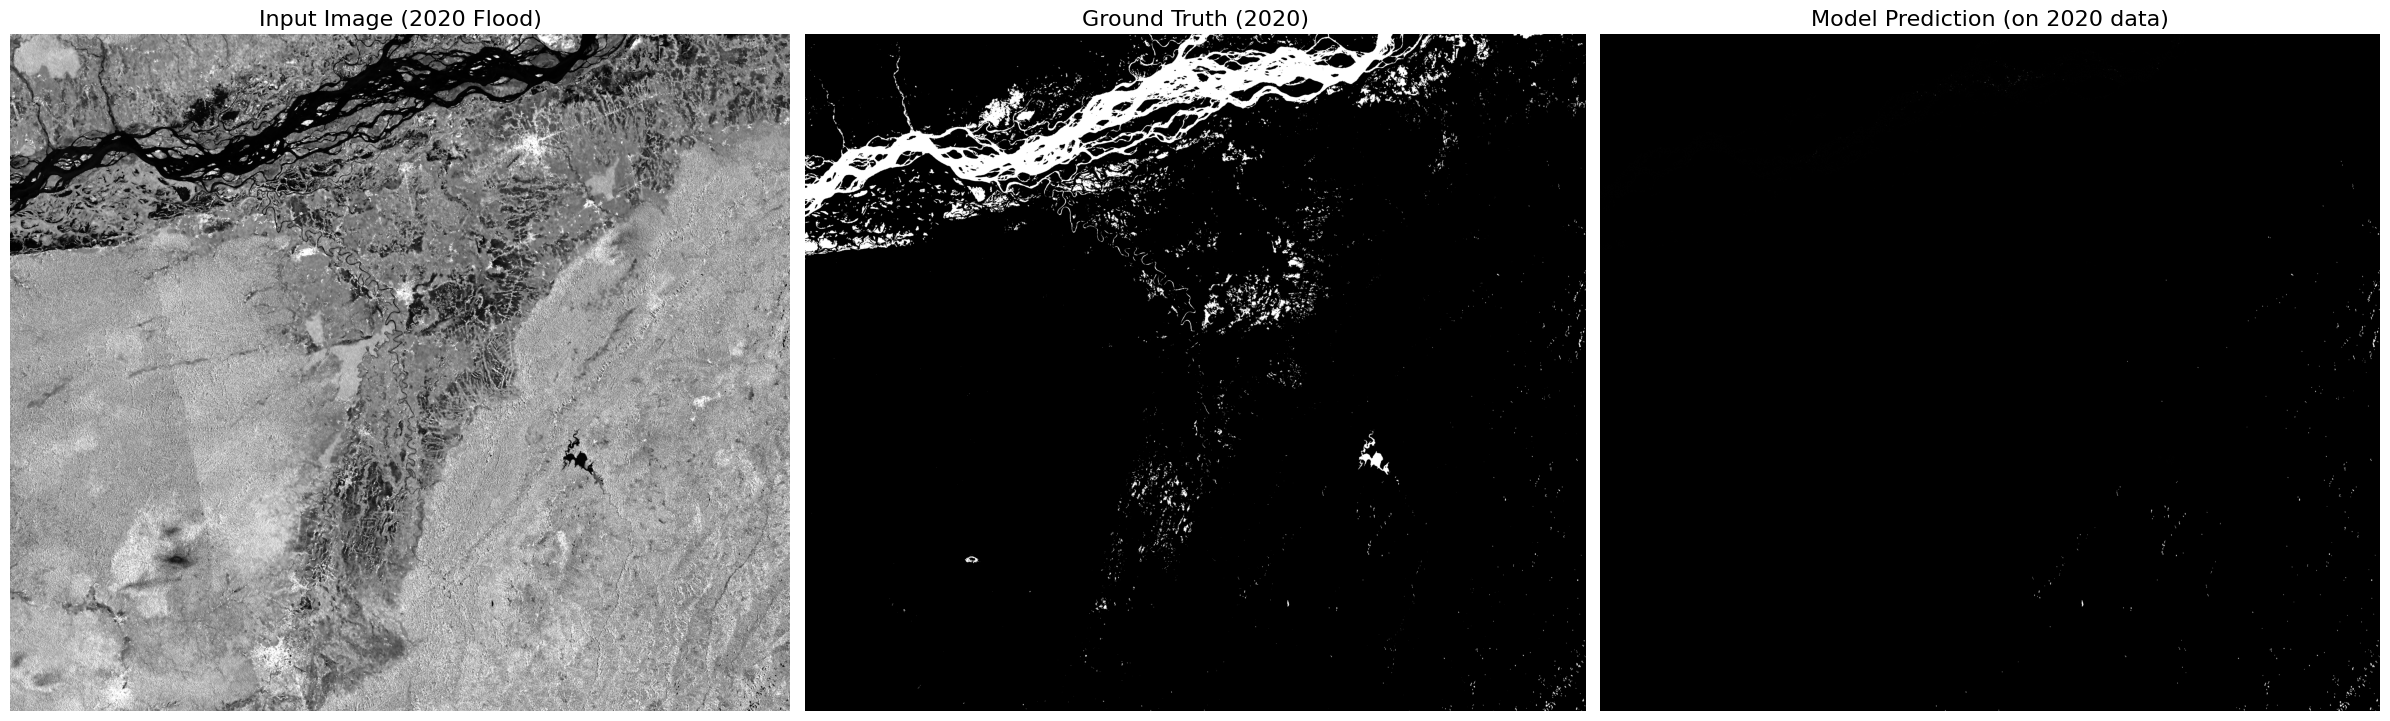

In [27]:
# Displaying the final test results
fig_2020, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 8))
ax1.imshow(during_flood_2020, cmap='gray', vmin=0.0, vmax=0.4); ax1.set_title('Input Image (2020 Flood)', fontsize=16); ax1.axis('off')
ax2.imshow(ground_truth_2020_correct, cmap='gray'); ax2.set_title('Ground Truth (2020)', fontsize=16); ax2.axis('off')
ax3.imshow(prediction_map_2020, cmap='gray'); ax3.set_title('Model Prediction (on 2020 data)', fontsize=16); ax3.axis('off')
plt.tight_layout(); plt.show()

In [28]:
accuracy_2020 = accuracy_score(ground_truth_2020_correct.flatten(), prediction_map_2020.flatten())
print(f"\nModel Accuracy on the 2020 flood event: {accuracy_2020 * 100:.2f}%")


Model Accuracy on the 2020 flood event: 99.94%


In [29]:
total_pixels_2020 = prediction_map_2020.size
water_pixels_2020 = np.sum(prediction_map_2020 == 1)
flood_percentage_2020 = (water_pixels_2020 / total_pixels_2020) * 100
print(f"Percentage of area detected as water: {flood_percentage_2020:.2f}%")

if flood_percentage_2020 > 5.0:
    print("Verdict: ✅ Significant Flood Detected")
else:
    print("Verdict: ❌ No Significant Flood Detected")

Percentage of area detected as water: 5.53%
Verdict: ✅ Significant Flood Detected


In [31]:
# 1. Save the Trained Model
model_filename = 'random_forest_flood_model.joblib'
model_save_path = os.path.join(base_path, model_filename)
joblib.dump(rf_model, model_save_path)
print(f" Model saved to: {model_save_path}")

# 2. Save the 2023 Prediction Map
prediction_filename_2023 = 'random_forest_prediction_2023.tif'
prediction_save_path_2023 = os.path.join(base_path, prediction_filename_2023)
with rasterio.open(during_flood_path_2023) as src:
    meta = src.meta
meta.update(count=1, dtype='uint8')
with rasterio.open(prediction_save_path_2023, 'w', **meta) as dst:
    dst.write(prediction_map_2023.astype(rasterio.uint8), 1)

# 3. Save the 2023 Comparison Figure
figure_filename_2023 = 'comparison_plot_2023.png'
figure_save_path_2023 = os.path.join(base_path, figure_filename_2023)
fig_2023.savefig(figure_save_path_2023)


 Model saved to: /content/drive/MyDrive/Flood_project/clipped_data/random_forest_flood_model.joblib
